
## Analyze customer sentiment from twitter data for airlines to make business recommendations for improvement

In [8]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import svm
from sklearn import tree
from IPython.display import Image # displaying images files in jupyter
from IPython.display import IFrame # displaying pdf file in jupyter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import scipy 
import scipy.stats as stats

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
import string

import matplotlib.pyplot as plt

In [9]:
# Input and clean up data by removing columns not useful for analysis
tweets = pd.read_csv('Tweets.csv')
del tweets['tweet_id']
del tweets['retweet_count']
del tweets['tweet_coord']
del tweets['name']
del tweets['airline_sentiment_gold']
del tweets['tweet_created']
del tweets['user_timezone']
tweets.head() 

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,negativereason_gold,text,tweet_location
0,neutral,1.0000,NaN,NaN,Virgin America,NaN,@VirginAmerica What @dhepburn said.,NaN
1,positive,0.3486,NaN,0.0000,Virgin America,NaN,@VirginAmerica plus you've added commercials t...,NaN
2,neutral,0.6837,NaN,NaN,Virgin America,NaN,@VirginAmerica I didn't today... Must mean I n...,Lets Play
3,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,@VirginAmerica it's really aggressive to blast...,NaN
4,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,@VirginAmerica and it's a really big bad thing...,NaN


In [10]:
# scanning data
print ("Airlines: ", tweets['airline'].dropna().unique())
print (" ")
print ("Sentiment: ", tweets['airline_sentiment'].dropna().unique())
print (" ")
print ("Negative comments: ", tweets['negativereason'].dropna().unique())
print (" ")
print ("Locations: ", tweets['tweet_location'].dropna().unique())

Airlines:  ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
 
Sentiment:  ['neutral' 'positive' 'negative']
 
Negative comments:  ['Bad Flight' "Can't Tell" 'Late Flight' 'Customer Service Issue'
 'Flight Booking Problems' 'Lost Luggage' 'Flight Attendant Complaints'
 'Cancelled Flight' 'Damaged Luggage' 'longlines']
 
Locations:  ['Lets Play' 'San Francisco CA' 'Los Angeles' ..., 'Columbus, OH, USA'
 'Milwaukee County, Wisconsin' 'Nigeria,lagos']


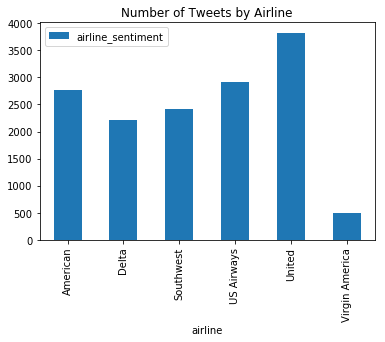

,airline_sentiment
airline,
American,2759
Delta,2222
Southwest,2420
US Airways,2913
United,3822
Virgin America,504


In [11]:
# Count of tweets by airline - sample size

df = tweets[['airline', 'airline_sentiment']]
a = pd.pivot_table(df, index = ['airline'], aggfunc = len)

a.plot(kind = 'bar', title = 'Number of Tweets by Airline')
plt.show()
a

In [61]:
# function to clean up Twitter text
def clean_tweet(str):

    str = str.lower() 
    tokens = nltk.word_tokenize(str)                            # tokenize
    tokens = [i for i in tokens if i not in string.punctuation] # remove punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [i for i in tokens if i not in stop_words]  # remove stop words
    tokens = [i for i in tokens if   not i.isdigit()]    # remove numbers
    tokens = [i for i in tokens if i.isalnum()]          # remove alpha numeric characters

    tokens = list(set(tokens)) # Remove duplicates.
    #print("Length: ", len(tokens))
    
    clean_text = ' '.join(token for token in tokens)
    
    return clean_text

In [62]:
# Add clean tweets field.
#print (tweets_train['text'][0])
#print (clean_tweet(tweets_train['text'][0]))
tweets['clean_tweet']= tweets['text'].apply(lambda s: clean_tweet(s))
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,negativereason_gold,text,tweet_location,predicted_sentiment,clean_tweet
0,neutral,1.0000,NaN,NaN,Virgin America,NaN,@VirginAmerica What @dhepburn said.,NaN,neutral,dhepburn said virginamerica
1,positive,0.3486,NaN,0.0000,Virgin America,NaN,@VirginAmerica plus you've added commercials t...,NaN,neutral,plus tacky added experience commercials virgin...
2,neutral,0.6837,NaN,NaN,Virgin America,NaN,@VirginAmerica I didn't today... Must mean I n...,Lets Play,neutral,mean need another today trip take must virgina...
3,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,@VirginAmerica it's really aggressive to blast...,NaN,neutral,blast amp guests recourse obnoxious faces real...
4,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,@VirginAmerica and it's a really big bad thing...,NaN,neutral,big really bad virginamerica thing


In [63]:
# Predictive Modeling, predicted_sentiment based on twitter text.
tweets['predicted_sentiment'] = 'neutral' # to begin with, it will be replaced by prediction.
tweets_train, tweets_test = train_test_split(tweets, test_size=0.10, random_state=42)
print ("Training: ", tweets_train.shape)
print ("Test: ", tweets_test.shape)

train_clean_tweet=[]
for t in tweets_train['clean_tweet']:
    train_clean_tweet.append(t)
test_clean_tweet=[]
for t in tweets_test['clean_tweet']:
    test_clean_tweet.append(t)

train_clean_tweet

Training:  (13176, 10)
Test:  (1464, 10)


['united yes made austin luggage sent minutes headed waiting',
 'days thanks full guys work missing americanair',
 'mobile overhaul app usairways needs major horrible',
 'upgraded since amp confirmed else app checked got counter somebody yesterday manager upgrade americanair seat carry',
 'phone united three disconnected times time got change tried flight',
 'united mandarinjourney offer try decisions status http love match service',
 'painful beyond sinuses missed rather landings frustrated preregistration contend two southwestair window one',
 'thanks wednesday believe help aa138 americanair scheduled return flight',
 'allowed clearly pit usairways explains bos make site sense carry',
 'united missing heartbroken sentimental items value',
 'process jetblue begins',
 'notice reason hard hours told jfk jetblue notify delay hour ca',
 'game jetblue buying',
 'running americanair version sure',
 'right somehow usairways bottles wine flights watered americanair served',
 'http jetblue fle

In [66]:
# Can I Predict Sentiment of the tweet (Positive or Negative) based on training 
# compare that predicted_sentiment with sentiment and find accuracy.

from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features = v.fit_transform(train_clean_tweet)
test_features  = v.fit_transform(test_clean_tweet)


<13176x11639 sparse matrix of type '<class 'numpy.int64'>'
	with 123935 stored elements in Compressed Sparse Row format>

In [ ]:
# Can I based on the features (Negative Comments, Airline, Tweet Text) predict Sentiment?
# Challenge features are descriptive (not 1/0) How to apply Tree, SVM, clustering?

## References:

(1) Dataset - Kaggle

(2) www.nltk.org

(3) http://scikit-learn.org/stable/modules/feature_extraction.html